### Importing Required Packages

In [0]:
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.types as t
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import lightgbm as lgbm
import shap
import os

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score
import sklearn.metrics as sk_metrics
from sklearn.metrics import r2_score

In [0]:
#Setting to prevent OoM issue while handling large chunk of data
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
spark.conf.set("spark.sql.execution.arrow.pyspark.fallback.enabled","false")

### Input Parameters

In [0]:
dbutils.widgets.removeAll()

In [0]:
dbutils.widgets.text("Country Name", "Germany")
dbutils.widgets.text("Product Name", "TRELEGY")
dbutils.widgets.text("Target DB Name", "opportunity_engine")
dbutils.widgets.text("Target Table Name Prefix", "opportunityengine")
dbutils.widgets.text("Start Yearmonth", "202103")
dbutils.widgets.text("End Yearmonth", "202209")

In [0]:
country_name = dbutils.widgets.get("Country Name")
product_name = dbutils.widgets.get("Product Name")
tgt_dbname = dbutils.widgets.get("Target DB Name")
tgt_tblname_prefix = dbutils.widgets.get("Target Table Name Prefix")
start_yearmonth = dbutils.widgets.get("Start Yearmonth")
end_yearmonth = dbutils.widgets.get("End Yearmonth")

In [0]:
TrainCV= spark.sql(f"select * from {tgt_dbname}.{tgt_tblname_prefix.lower()}_{country_name.lower()}_{product_name.lower()}_v3 where Initiation_Candidate=0 and {start_yearmonth} <=yearmonth and yearmonth<= {end_yearmonth} ")
Test= spark.sql(f"select * from {tgt_dbname}.{tgt_tblname_prefix.lower()}_{country_name.lower()}_{product_name.lower()}_v3 where Initiation_Candidate=0 and yearmonth> {end_yearmonth} ")

#### Create the column Switch_toF2F

In [0]:
TrainCV = TrainCV.withColumn(
    'Switch_toF2F',
    f.when((f.col("MONTHS_SINCE_DIGITAL_to_F2F_SWITCH").isNotNull()) | (f.col("MONTHS_SINCE_NO_ACTIVITY_to_F2F_SWITCH").isNotNull()), 1)\
    .otherwise(0)
)
Test = Test.withColumn(
    'Switch_toF2F',
    f.when((f.col("MONTHS_SINCE_DIGITAL_to_F2F_SWITCH").isNotNull()) | (f.col("MONTHS_SINCE_NO_ACTIVITY_to_F2F_SWITCH").isNotNull()), 1)\
    .otherwise(0)
)

In [0]:
print(TrainCV.count())
print(Test.count())

640916
101140


#### Data Preprocessing

In [0]:
def convert_toPandas(sparkdf):
  sparkdf_pd= sparkdf.toPandas()
  sparkdf_pd = sparkdf_pd.dropna(subset=['AVG_SALES'])
  sparkdf_pd.replace(r'\s+', np.nan, regex=True)
  sparkdf_pd.fillna(value = np.nan,inplace=True) 
  sparkdf.unpersist()
  return sparkdf_pd
  

In [0]:
TrainCV_df = convert_toPandas(TrainCV)
Test_df = convert_toPandas(Test)

In [0]:
def data_conversion_split(df):
  X=df[['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION', 'SPECIALTY_1', 'SPECIALTY_2', 'RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID', 'RX_ATTITUDINAL_SEGMENTATION','HAS_ACTIVE_PLAN', 'SHARE_ELEBRATO_ELLIPTA', 'SHARE_TRELEGY','SHARE_TRIMBOW','SHARE_RELVAR', 'SHARE_SITT', 'SHARE_LABA/LAMA', 'SHARE_ICS/LABA','SHARE_ONCE_DAILY', 'SHARE_TWICE_DAILY', 'SHARE_MDI', 'SHARE_DPI','MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT','RX_SEGMENT','RX_CUSTOMER_JOURNEY','CURRENCY_CODE','VOL_ELEBRATO_ELLIPTA','VOL_TRELEGY','VOL_SITT','VOL_TRIMBOW','VOL_LABA/LAMA','VOL_TRIMBOW_NEXTHALER_+_PI','VOL_TRIXEO','MONTHS_SINCE_DIGITAL_to_F2F_SWITCH','MONTHS_SINCE_NO_ACTIVITY_to_F2F_SWITCH','MONTHS_SINCE_F2F_to_DIGITAL_SWITCH']]
  Y=df[[ 'AVG_SALES']]
  pd.set_option('mode.chained_assignment', None)  
  X[['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION', 'SPECIALTY_1', 'SPECIALTY_2','RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID','RX_ATTITUDINAL_SEGMENTATION', 'HAS_ACTIVE_PLAN', 'MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT' ,'RX_SEGMENT','RX_CUSTOMER_JOURNEY','CURRENCY_CODE']]=X[['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION', 'SPECIALTY_1', 'SPECIALTY_2','RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID','RX_ATTITUDINAL_SEGMENTATION', 'HAS_ACTIVE_PLAN', 'MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT' ,'RX_SEGMENT','RX_CUSTOMER_JOURNEY','CURRENCY_CODE']].astype(str)
  return X,Y

In [0]:
X_TrainCV,Y_TrainCV = data_conversion_split(TrainCV_df)
X_Test,Y_Test=data_conversion_split(Test_df)

#### Define the preprocessing pipeline

In [0]:
def preprocessing_pipeline(numeric_features,categorical_features):
  numeric_transformer = Pipeline(
  steps=[("imputer_num", SimpleImputer(strategy='constant',fill_value=0)), 
         ("scaler", StandardScaler())]
                                )

  categorical_transformer = Pipeline(
  steps=[
    ("imputer_cat", SimpleImputer(strategy='constant',fill_value='missing')),  
    ("encoder", OneHotEncoder(handle_unknown="ignore"))]
                                    )
  preprocessor = ColumnTransformer(
  transformers=[
      ("cat", categorical_transformer, categorical_features),
      ("num", numeric_transformer, numeric_features)
      
                ],remainder='passthrough'
                                  )
  return preprocessor


In [0]:
numeric_features = [ 'SHARE_ELEBRATO_ELLIPTA', 'SHARE_TRELEGY','SHARE_TRIMBOW','SHARE_RELVAR', 'SHARE_SITT', 'SHARE_LABA/LAMA', 'SHARE_ICS/LABA','SHARE_ONCE_DAILY', 'SHARE_TWICE_DAILY', 'SHARE_MDI', 'SHARE_DPI','VOL_ELEBRATO_ELLIPTA','VOL_TRELEGY','VOL_SITT','VOL_TRIMBOW','VOL_LABA/LAMA','VOL_TRIMBOW_NEXTHALER_+_PI','VOL_TRIXEO','MONTHS_SINCE_DIGITAL_to_F2F_SWITCH','MONTHS_SINCE_NO_ACTIVITY_to_F2F_SWITCH','MONTHS_SINCE_F2F_to_DIGITAL_SWITCH']

categorical_features=['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION','SPECIALTY_1','SPECIALTY_2','RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID','RX_ATTITUDINAL_SEGMENTATION', 'HAS_ACTIVE_PLAN', 'MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT' ,'RX_SEGMENT','RX_CUSTOMER_JOURNEY','CURRENCY_CODE']

preprocess= preprocessing_pipeline(numeric_features,categorical_features)

In [0]:
#Convert to Numpy Array after call to preprocess function
X_TrainCV_transformed=(preprocess.fit_transform(X_TrainCV)).toarray()
X_Test_transformed=(preprocess.transform(X_Test)).toarray()
Y_TrainCV_transformed = (Y_TrainCV.astype(float)).to_numpy()
Y_Test_transformed = (Y_Test.astype(float)).to_numpy()

#### Define Custom loss function

In [0]:
from scipy.special import softmax
def grad_hess_mean_normal(y_true: np.ndarray, y_pred: np.ndarray):
        """Gradient and hessian for the combination mean aggregation - Normal
        distribution."""
        k = y_pred.shape[0]
        y = y_true  
        grad = np.ones(k) / k * (y_pred.mean() - y)
        hess = np.ones(k) / k**2
        return grad, hess
      
def grad_hess_sum_poisson(y_true: np.ndarray, y_pred: np.ndarray):
        """Gradient and hessian for the combination sum aggregation - Poisson
        distribution."""
        k = y_pred.shape[0]
        y = y_true   
        soft_y = softmax(y_pred)
        grad = np.ones(k) * (np.exp(y_pred) - y * soft_y)
        hess = np.ones(k) * (np.exp(y_pred) - y * soft_y * (1 - soft_y))
        return grad, hess

#### Perform K-Fold Cross validation

In [0]:
#Hyperparameters
hyperparameter_dictionary={
'boosting_type':	'gbdt',
'n_estimators':1500,
'colsample_bytree':	.3,
'early_stopping_rounds':None,
'importance_type':'split',
'learning_rate':0.01,
'max_depth':4,
'min_child_samples':20,
'min_child_weight':	0.001,
'min_split_gain':	0.0,
'n_jobs':-1,
'num_leaves':	20,
'objective':'regression',
'random_state':	None,
'class_weight':None,
'reg_alpha':	0.0,
'reg_lambda':	0.0,
'subsample':	.3,
'subsample_for_bin':200000,
'subsample_freq':	0,
'verbose':	-1
}


In [0]:
# Train a LightGBM model with the custom loss function and "learning from aggregate"
models = lgbm.LGBMRegressor(**hyperparameter_dictionary)
models.fit(X_TrainCV_transformed, Y_TrainCV_transformed.ravel(),eval_metric=[grad_hess_mean_normal])
Y_pred = models.predict(X_Test_transformed)
print(r2_score(Y_Test_transformed, Y_pred))

0.69150009172066


In [0]:
# Validate the LightGBM model using K-Fold Cross Validation
model = lgbm.LGBMRegressor(**hyperparameter_dictionary)
kfold = KFold(n_splits=5, shuffle=True, random_state=11)
scores1 = []
for train_index, test_index in kfold.split(X_TrainCV_transformed):
    Xtrain, Xcv = X_TrainCV_transformed[train_index], X_TrainCV_transformed[test_index]
    Ytrain, Ycv = Y_TrainCV_transformed[train_index], Y_TrainCV_transformed[test_index]
    model.fit(Xtrain, Ytrain.ravel(),eval_metric=[grad_hess_mean_normal])
    score1 = model.score(Xcv, Ycv)
    scores1.append(score1)
mean1=np.mean(scores1)
std1=np.std(scores1)
print(f'R2-score during Cross-validation are:{scores1}')
print(f"\nMean R2 score with standard deviation is: {mean1:.2f} +/- {std1:.2f}")

R2-score during Cross-validation are:[0.7343740716622836, 0.7282962140953103, 0.7330506966797219, 0.7367264780258077, 0.7288811529672644]

Mean R2 score with standard deviation is: 0.73 +/- 0.00


###SHAP

In [0]:
#Add headers to transformed features and get SHAP values
feature_list=preprocess.transformers_[0][1]['encoder'].get_feature_names(categorical_features)
feature_list=feature_list.tolist()
feature_list.extend(numeric_features)
X_Test_df= pd.DataFrame(X_Test_transformed ,columns= feature_list)
explainer = shap.Explainer(models,X_Test_df)
shap_values = explainer(X_Test_df)

 15%|===                 | 15149/101

*** WARNING: max output size exceeded, skipping output. ***

100%|===================| 101118/101136 [45:47<00:00]       

In [0]:
def shap_plot(plot_function): 
    p=plot_function
    plt.savefig('shap.svg')
    plt.close()
    return p
    os.remove('shap.svg')

#### Bar plot for Feature Importance

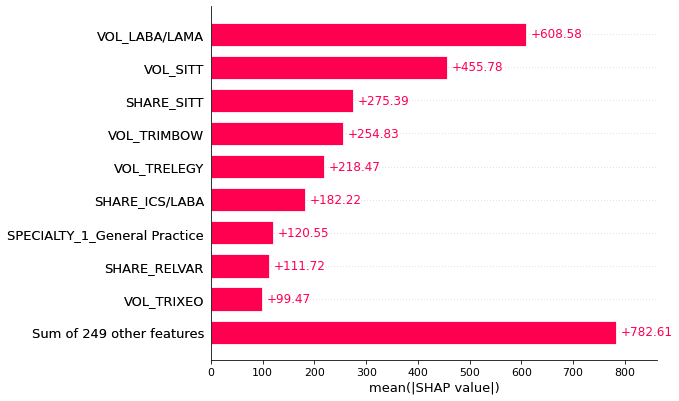

In [0]:
shap_plot(shap.plots.bar(shap_values.abs.mean(0)))

#### Beeswarm plot for Feature Importance

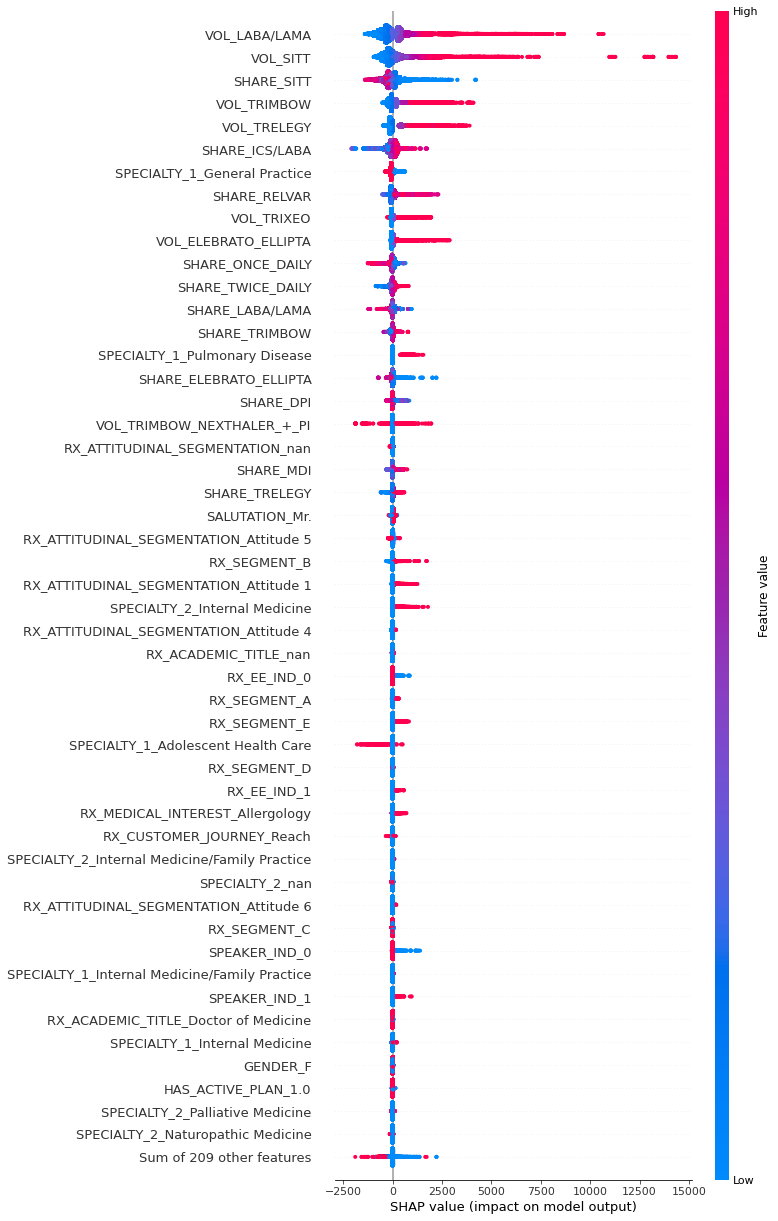

In [0]:
shap_plot(shap.plots.beeswarm(shap_values, max_display=50))

####Map the Rep. data with the rest of data

In [0]:
# #Read the data and convert it to desired format
# rephcp = spark.read.table(f"{tgt_dbname}.RepHCP_mapping_{country_name.lower()}_{product_name.lower()}")
# rephcp_df =rephcp.toPandas()
# rephcp.unpersist()

#### Store the results in database

In [0]:
Account_df = Test_df[['ACCOUNT_ID' , 'PRODUCT_NAME' ,'RX_EU5_GSK_NANO_BRICK' ,'NANOBRICK' , 'RX_SEGMENT','RX_CUSTOMER_JOURNEY','YEARMONTH' ,'SHARE_TRELEGY','SHARE_SITT' ,'CALL_TYPE_WITH_MAX_INTERACTION','Switch_toF2F']]
Sales_df =pd.DataFrame(np.c_[Y_Test_transformed,Y_pred] ,columns= ["AVERAGE_SALES","PREDICTED_SALES"])
Account_df.reset_index(drop=True, inplace=True)
Sales_df.reset_index(drop=True, inplace=True)
Aggregates= pd.concat([Account_df,Sales_df], axis=1, ignore_index=False)
# Aggregates_joined = Aggregates.merge(rephcp_df, on='ACCOUNT_ID', how='left')
# print(Aggregates_joined.head())
# print(len(Aggregates_joined))

In [0]:
mySchema = t.StructType([ t.StructField("ACCOUNT_ID", t.LongType(), True)\
                       ,t.StructField("PRODUCT_NAME", t.StringType(), True)\
                      ,t.StructField("RX_EU5_GSK_NANO_BRICK", t.StringType(), True)\
                      ,t.StructField("NANOBRICK", t.StringType(), True)\
                      ,t.StructField("RX_SEGMENT", t.StringType(), True)\
                      ,t.StructField("RX_CUSTOMER_JOURNEY", t.StringType(), True)\
                       ,t.StructField("YEARMONTH", t.DoubleType(), True)\
                      ,t.StructField("SHARE_TRELEGY", t.FloatType(), True)\
                       ,t.StructField("SHARE_SITT", t.FloatType(), True)\
                       ,t.StructField("CALL_TYPE_WITH_MAX_INTERACTION", t.StringType(), True)\
                       ,t.StructField("Switch_toF2F", t.IntegerType(), True)\
                       ,t.StructField("AVERAGE_SALES", t.FloatType(), True)\
                       ,t.StructField("PREDICTED_SALES", t.FloatType(), True)\
                      #  ,t.StructField("USER_ID", t.StringType(), True)
                      ])
Py_Aggregates =  spark.createDataFrame(Aggregates,schema=mySchema)
Py_Aggregates.write.mode("overwrite").option("mergeSchema", "true").saveAsTable(
    f"{tgt_dbname}.aggregate_new_{country_name.lower()}_{product_name.lower()}"
)

In [0]:
# spark.sql('drop table opportunity_engine.aggregate_new_germany_trelegy')